In [1]:
import pandas as pd
import numpy as np

In [34]:
h1 = pd.read_csv('fakeHospital1_results.csv')
h2 = pd.read_csv('fakeHospital2_results.csv')
h1.head()
h1 = h1.rename(columns={"Unnamed: 0": "LLM Model", 'precision': 'Precision', 'recall': 'Recall', 'f1score': 'F1-Score'})
h2 = h2.rename(columns={"Unnamed: 0": "LLM Model", 'precision': 'Precision', 'recall': 'Recall', 'f1score': 'F1-Score'})

h2.head()

,LLM Model,Precision,Recall,F1-Score
0,llama3.21b,64.444444,39.189189,48.739496
1,granite3.32b,95.312500,70.930233,81.333333
2,gemma31b-it-qat,85.507246,67.816092,75.641026
3,gpt-4o-mini,92.957746,75.862069,83.544304
4,mistralai/devstral-smallfree,84.337349,81.395349,82.840237


In [30]:
h1 = h1.rename(columns={"Unnamed: 0": "LLM Model", 'precision': 'Precision', 'recall': 'Recall', 'f1score': 'F1-Score'})
h2 = h2.rename(columns={"Unnamed: 0": "LLM Model", 'precision': 'Precision', 'recall': 'Recall', 'f1score': 'F1-Score'})


In [35]:
h1.head()

,LLM Model,Precision,Recall,F1-Score
0,qwen2.5vl3b,66.197183,59.493671,62.666667
1,gemma31b-it-qat,85.074627,69.512195,76.510067
2,granite3.32b,29.508197,31.578947,30.508475
3,llama3.21b,94.000000,55.294118,69.629630
4,gpt-4o-mini,81.159420,71.794872,76.190476


/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_75350/60669827.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LLM Model', y='F1-Score', data=hospital_data, palette='viridis')


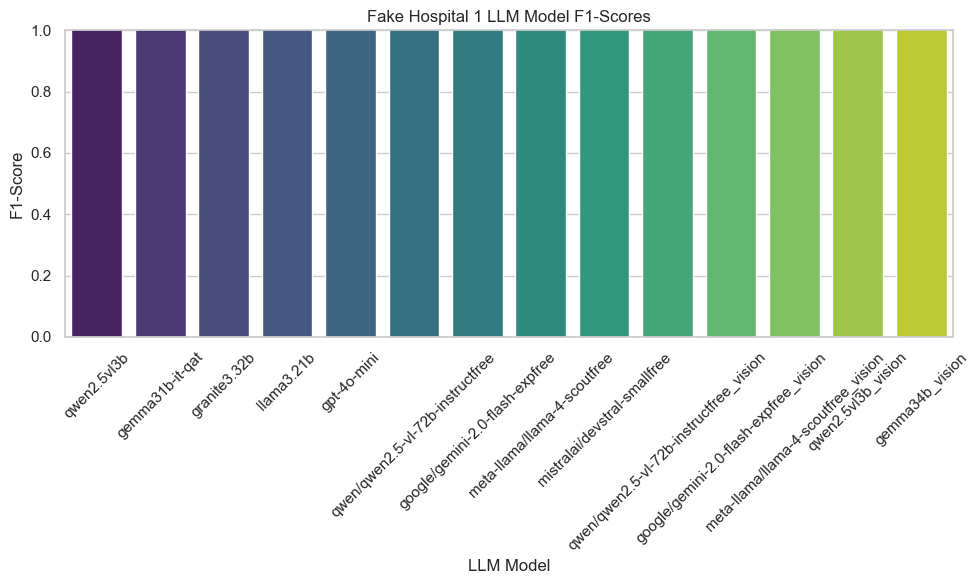

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_75350/60669827.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LLM Model', y='F1-Score', data=hospital_data, palette='viridis')


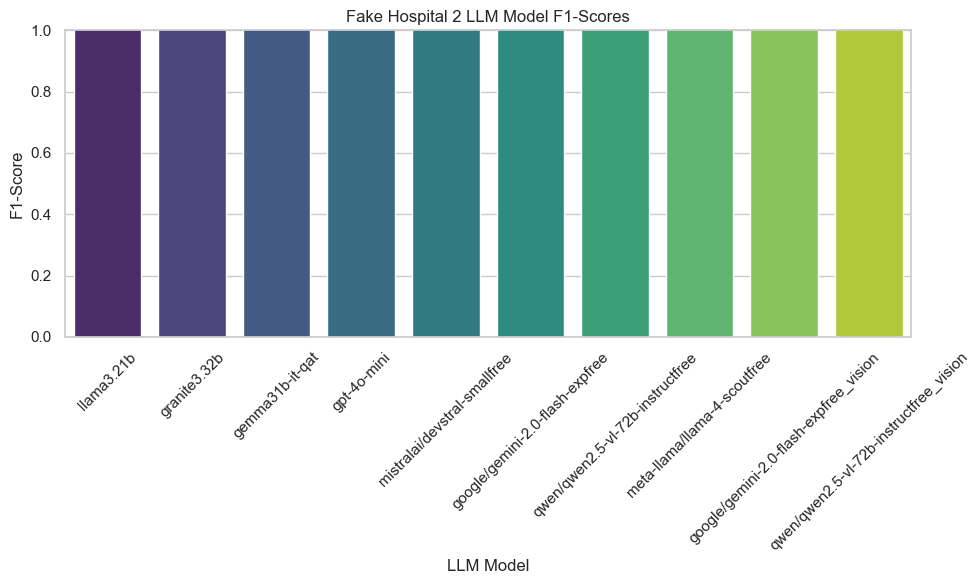

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
def plot_results(hospital_data, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='LLM Model', y='F1-Score', data=hospital_data, palette='viridis')
    plt.title(title)
    plt.xlabel('LLM Model')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
plot_results(h1, 'Fake Hospital 1 LLM Model F1-Scores')
plot_results(h2, 'Fake Hospital 2 LLM Model F1-Scores')

str

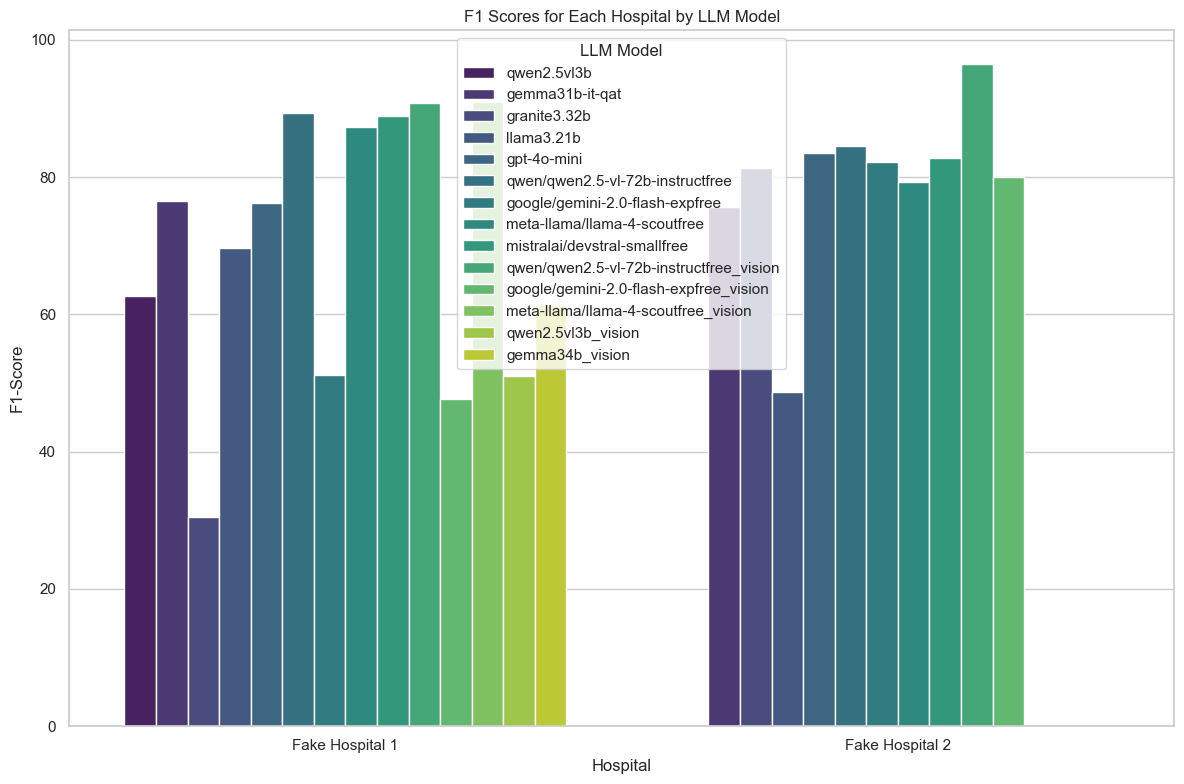

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine the data for both hospitals
h1['Hospital'] = 'Fake Hospital 1'
h2['Hospital'] = 'Fake Hospital 2'
combined_data = pd.concat([h1, h2])

# Plot the F1 scores for each hospital
plt.figure(figsize=(12, 8))
sns.barplot(x='Hospital', y='F1-Score', hue='LLM Model', data=combined_data, palette='viridis')
plt.title('F1 Scores for Each Hospital by LLM Model')
plt.xlabel('Hospital')
plt.ylabel('F1-Score')
plt.legend(title='LLM Model', loc='best')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()